In [1]:
%matplotlib inline

import seaborn as sns
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import re
from itertools import izip

In [2]:
def read_file(filename):
    df = pd.read_table(filename) \
        .assign(samplename = os.path.basename(filename.replace('.bed','')))
    return df

def filter_samples(d):
    return d[d.samplename.str.contains('umi|SRR')]\
        .pipe(lambda x: x[x.samplename.str.contains('rmdup|P1022_[12]')])\
        .pipe(lambda x: x[~x.samplename.str.contains('0033|0032')]) 
        
def assign_prep(x):
    return 'ssDNA-seq' if 'SRR' in x else 'TGIRT-seq'

def assign_sample(x):
    if re.search('005[12]|^P1|^PD', x):
        return 'Healthy'
    elif re.search('SRR2130004', x):
        return 'Breast cancer (Invasive/infiltrating ductal)'
    elif re.search('0011|0032|0045', x):
        return 'Breast cancer (Invasive/infiltrating lobular)'
    elif re.search('0043|0033', x):
        return 'Breast cancer (Ductal carcinoma in situ)'

In [ ]:
datapath = '/stor/work/Lambowitz/cdw2854/plasmaDNA/genomeWPS/tss_periodicity'
figurename = datapath + '/tss_cor_map.pdf'
files = glob.glob(datapath + '/*bed')
df = map(read_file, files)
df = pd.concat(df, axis=0) \
    .query('periodicity < 199 & periodicity > 193')\
    .groupby(['samplename','name','type','id']) \
    .mean() \
    .reset_index()
df.head()

In [ ]:
pdf = pd.pivot_table(filter_samples(df), 
                    columns = 'samplename', 
                    values = 'intensity', 
                    index = ['id','name','type']) \
    .reset_index()

In [ ]:
cor_mat = pdf.drop(['id','name','type'], axis=1)\
    .corr()\
    .reset_index()\
    .fillna(0)\
    .drop('samplename',axis=1)
cor_mat.index = cor_mat.columns

In [ ]:
color_df = pd.DataFrame({'samplename':cor_mat.columns}) \
    .assign(prep = lambda d: map(assign_prep, d.samplename))\
    .assign(sample = lambda d: map(assign_sample, d.samplename))\
    .drop('samplename',axis=1)
color_df.index = cor_mat.columns

factors = np.append(color_df.prep.unique(), color_df['sample'].unique())
color_label = {i:j for i,j in izip(factors, sns.color_palette('husl'))}
color_df['prep'] = map(lambda x: color_label[x], color_df['prep'])
color_df['sample'] = map(lambda x: color_label[x], color_df['sample'])
color_df.columns = map(lambda x: x.capitalize(), color_df.columns)

In [ ]:
with sns.plotting_context('paper', font_scale=1.5):
    p = sns.clustermap(cor_mat,
                   row_colors = color_df,
                   col_colors = color_df,
                   cmap='viridis', 
                   figsize=(8,8),
                   vmin=0, vmax=1)
r= plt.setp(p.ax_heatmap.get_yticklabels(), rotation=0)  
r=plt.setp(p.ax_heatmap.get_xticklabels(), rotation=90)
for label in factors:
    p.ax_col_dendrogram.bar(0, 0, color=color_label[label],
                            label=label, linewidth=0)
p.ax_col_dendrogram.legend(loc=(0.1,-11), ncol=2, fontsize=15)
p.cax.set_position([.98, .2, .03, .45])
p.ax_heatmap.set_position([.35,.1,.6,.6])
p.ax_row_dendrogram.set_position([.24,.1,.07,.6])
p.ax_row_colors.set_position([.31,.1,.03,.6])
p.ax_col_dendrogram.set_position([.35,.74,.6,.07])
p.ax_col_colors.set_position([.35,.71,.6,.03])
p.ax_heatmap.set_xticklabels([])
p.ax_heatmap.set_yticklabels([])
p.ax_heatmap.set(xlabel = ' ', ylabel=' ')
p.savefig(figurename, transparent=True)
print 'Plotted %s' %figurename

# Running a scatter plot

In [38]:
def get_max_period(d):
    I = d['intensity'].values
    P = d['periodicity'].values
    return P[I==I.max()][0]

In [134]:
gene_expression_table = '/stor/work/Lambowitz/cdw2854/plasmaDNA/genes/rna.csv'
ge = pd.read_csv(gene_expression_table)
ge.columns = ['id','name','cells','TPM','unit']
ge = ge\
    .drop('unit',axis=1) \
    .groupby(['id','name']) \
    .agg({'TPM':np.sum}) \
    .reset_index() \
    .sort_values('TPM', ascending = False)\
    .assign(quantile_group = lambda d: pd.qcut(d.TPM,4))
ge.head()

datapath = '/stor/work/Lambowitz/cdw2854/plasmaDNA/genomeWPS/tss_periodicity'
figurename = datapath + '/tss_cor_map.pdf'
files = glob.glob(datapath + '/*bed')
files = filter(lambda x: re.search('P1022_2_S4_umi2id_unique|SRR2130051_rmdup', x), files)
df = map(read_file, files)
df = pd.concat(df, axis=0) \
    .assign(periodicity = lambda d: np.array(d.periodicity, dtype='int64'))\
    .groupby(['samplename','name','type','id']) \
    .apply(get_max_period) \
    .reset_index() \
    .rename(columns = {0:'periodicity'})\
    .merge(ge, 'inner') \
    .drop('TPM',axis=1) 
df.head()

,samplename,name,type,id,periodicity,quantile_group
0,P1022_2_S4_umi2id_unique,A1BG,protein_coding,ENSG00000121410,212,"(166.7, 821.1]"
1,SRR2130051_rmdup,A1BG,protein_coding,ENSG00000121410,181,"(166.7, 821.1]"
2,P1022_2_S4_umi2id_unique,A1CF,protein_coding,ENSG00000148584,217,"(166.7, 821.1]"
3,SRR2130051_rmdup,A1CF,protein_coding,ENSG00000148584,181,"(166.7, 821.1]"
4,P1022_2_S4_umi2id_unique,A2M,protein_coding,ENSG00000175899,204,"(2338.625, 1280187.2]"


In [135]:
pdf = pd.pivot_table(filter_samples(df), 
                    columns = 'samplename', 
                    values = 'periodicity', 
                    index = ['id','name','type','quantile_group']) \
    .reset_index()\
    .drop(['id','name','type'], axis=1) 
#    .query('periodicity > 193 & periodicity < 199')
pdf.head()

samplename,quantile_group,P1022_2_S4_umi2id_unique,SRR2130051_rmdup
0,"(2338.625, 1280187.2]",185,185
1,"[0, 166.7]",181,185
2,"(2338.625, 1280187.2]",200,181
3,"(166.7, 821.1]",217,175
4,"(166.7, 821.1]",185,175


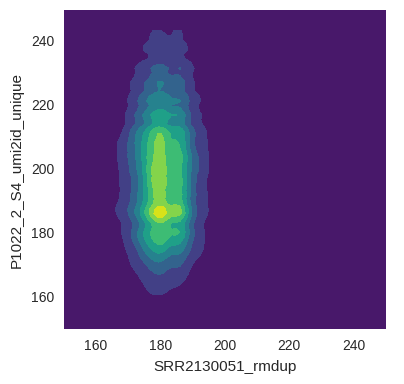

In [138]:
p = sns.FacetGrid(data=pdf, 
                  #hue = 'quantile_group', 
                  legend_out = True,
                  aspect = 1,
                  size = 4)
p.map(sns.kdeplot,'SRR2130051_rmdup','P1022_2_S4_umi2id_unique', 
      cmap='viridis',shade=True, bw = 2)
p.add_legend()
#p.fig.axes[0].set_xscale('log')
#p.fig.axes[0].set_yscale('log')
          #        shade=True, cmap='viridis')
p.set(xlim=(150,250), ylim=(150,250))
#ax.annotate(r'$\rho =$ %.3f' %cor, xy=(200,200), fontsize = 20)